In [1]:
# Uncomment to run the notebook in Colab
# ! pip install -q "wax-ml[complete]@git+https://github.com/eserie/wax-ml.git"
# ! pip install -q --upgrade jax jaxlib==0.1.70+cuda111 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from functools import partial

import jax
import jax.numpy as jnp
import numpy as onp
import pandas as pd
from jax.config import config

from wax.modules.ewma import EWMA
from wax.unroll import unroll_transform_with_state

/Users/emmanuelserie/mambaforge/envs/waxml39/lib/python3.9/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
# check available devices
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))
jax.devices()

jax backend cpu


In [4]:
adjust = True
ignore_na = False
config.update("jax_enable_x64", True)

T = 20

x = jnp.full((T,), jnp.nan).at[0].set(1).at[10].set(-1)

rng = jax.random.PRNGKey(38)
x = jax.random.normal(rng, (T,))

x = jnp.full((T,), jnp.nan).at[2].set(1).at[10].set(-1)


@partial(unroll_transform_with_state, dynamic=True)
def fun(x):
    return EWMA(1 / 10, adjust=adjust, ignore_na=ignore_na, return_info=True)(x)


rng = jax.random.PRNGKey(42)
params, state = fun.init(rng, x)
(res, info), final_state = fun.apply(params, state, rng, x)


res = pd.DataFrame(onp.array(res))

ref_res = (
    pd.DataFrame(onp.array(x))
    .ewm(alpha=1 / 10, adjust=adjust, ignore_na=ignore_na)
    .mean()
)

In [5]:
res

,0
0,NaN
1,NaN
2,1.000000
3,1.000000
4,1.000000
5,1.000000
6,1.000000
7,1.000000
8,1.000000
9,1.000000


In [6]:
ref_res

,0
0,NaN
1,NaN
2,1.000000
3,1.000000
4,1.000000
5,1.000000
6,1.000000
7,1.000000
8,1.000000
9,1.000000


In [7]:
info

{'com_eff': DeviceArray([0.        , 0.        , 0.        , 0.9       , 0.81      ,
              0.729     , 0.6561    , 0.59049   , 0.531441  , 0.4782969 ,
              0.43046721, 1.28742049, 1.15867844, 1.0428106 , 0.93852954,
              0.84467658, 0.76020892, 0.68418803, 0.61576923, 0.55419231],            dtype=float64)}

In [8]:
pd.testing.assert_frame_equal(res, ref_res, atol=1.0e-6)

##  check gradient

In [9]:
@jax.value_and_grad
def batch(params):
    (res, info), final_state = fun.apply(params, state, rng, x)
    return jnp.nanmean(res)


score, grad = batch(params)
assert not jnp.isnan(grad["ewma"]["logcom"])
score, grad

(DeviceArray(0.223253, dtype=float64),
 FlatMap({'ewma': FlatMap({'logcom': DeviceArray(0.18699575, dtype=float64)})}))

# Linear adjustement

In [10]:
adjust = True
ignore_na = False
config.update("jax_enable_x64", True)

T = 20

x = jnp.full((T,), jnp.nan).at[0].set(1).at[10].set(-1)

rng = jax.random.PRNGKey(38)
x = jax.random.normal(rng, (T,))

In [11]:
from wax.unroll import unroll

<AxesSubplot:>

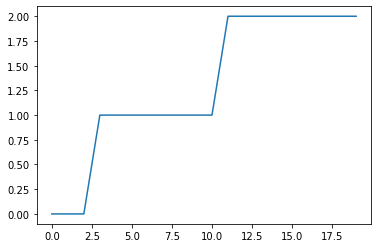

In [12]:
x = jnp.full((20,), jnp.nan).at[2].set(1).at[10].set(-1)
(res, info) = unroll(
    lambda x: EWMA(com=10, adjust="linear", ignore_na=True, return_info=True)(x)
)(x)
res = pd.DataFrame(onp.array(res))
pd.Series(info["com_eff"]).plot()

In [13]:
# rng = jax.random.PRNGKey(42)
# x = jax.random.normal(rng, (100,)).at[30:50].set(jnp.nan)
# x = jnp.full((100,), jnp.nan).at[2].set(1).at[10].set(-1)

<AxesSubplot:>

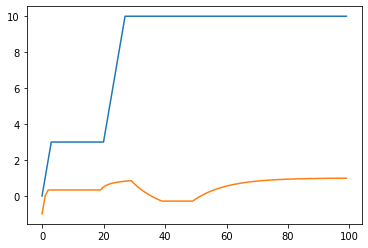

In [14]:
x = (
    jnp.ones((100,))
    .at[0]
    .set(-1)
    .at[30:50]
    .set(-1)
    .at[40:50]
    .set(jnp.nan)
    .at[3:20]
    .set(jnp.nan)
)

(res, info) = unroll(
    lambda x: EWMA(com=10, adjust="linear", ignore_na=True, return_info=True)(x)
)(x)
res = pd.Series(onp.array(res))
pd.Series(info["com_eff"]).plot()
res.plot()

<AxesSubplot:>

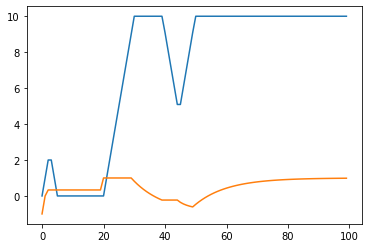

In [15]:
x = (
    jnp.ones((100,))
    .at[0]
    .set(-1)
    .at[30:50]
    .set(-1)
    .at[40:45]
    .set(jnp.nan)
    .at[3:20]
    .set(jnp.nan)
)

(res, info) = unroll(
    lambda x: EWMA(com=10, adjust="linear", ignore_na=False, return_info=True)(x)
)(x)
res = pd.Series(onp.array(res))
pd.Series(info["com_eff"]).plot()
res.plot()

<AxesSubplot:>

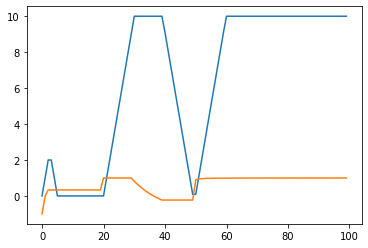

In [16]:
x = (
    jnp.ones((100,))
    .at[0]
    .set(-1)
    .at[30:50]
    .set(-1)
    .at[40:50]
    .set(jnp.nan)
    .at[3:20]
    .set(jnp.nan)
)

(res, info) = unroll(
    lambda x: EWMA(com=10, adjust="linear", ignore_na=False, return_info=True)(x)
)(x)
res = pd.Series(onp.array(res))
pd.Series(info["com_eff"]).plot()
res.plot()

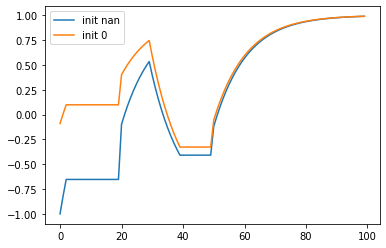

In [17]:
x = (
    jnp.ones((100,))
    .at[0]
    .set(-1)
    .at[30:50]
    .set(-1)
    .at[40:50]
    .set(jnp.nan)
    .at[3:20]
    .set(jnp.nan)
)

(res, info) = unroll(
    lambda x: EWMA(
        com=10, adjust=False, ignore_na=False, return_info=True, initial_value=jnp.nan
    )(x)
)(x)
res = pd.Series(onp.array(res))
# pd.Series(info["com_eff"]).plot()
res.plot()
(res, info) = unroll(
    lambda x: EWMA(
        com=10, adjust=False, ignore_na=False, return_info=True, initial_value=0.0
    )(x)
)(x)
res = pd.Series(onp.array(res))
# pd.Series(info["com_eff"]).plot()
res.plot()
plt.legend(("init nan", "init 0"))

<AxesSubplot:>

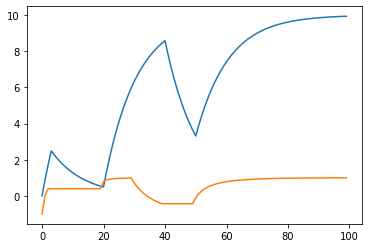

In [18]:
x = (
    jnp.ones((100,))
    .at[0]
    .set(-1)
    .at[30:50]
    .set(-1)
    .at[40:50]
    .set(jnp.nan)
    .at[3:20]
    .set(jnp.nan)
)

(res, info) = unroll(
    lambda x: EWMA(com=10, adjust=True, ignore_na=False, return_info=True)(x)
)(x)
res = pd.Series(onp.array(res))
pd.Series(info["com_eff"]).plot()
res.plot()

<AxesSubplot:>

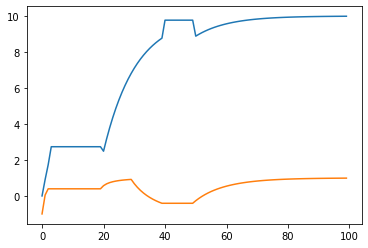

In [19]:
x = (
    jnp.ones((100,))
    .at[0]
    .set(-1)
    .at[30:50]
    .set(-1)
    .at[40:50]
    .set(jnp.nan)
    .at[3:20]
    .set(jnp.nan)
)

alpha = 1 / (1 + 10)
(res, info) = unroll(
    lambda x: EWMA(com=10, adjust=True, ignore_na=True, return_info=True)(x),
    dynamic=False,
)(x)
res = pd.Series(onp.array(res))
pd.Series(info["com_eff"]).plot()
# pd.Series(info["old_wt"]/alpha).plot()

res.plot()

# Exponential adjustement

<AxesSubplot:>

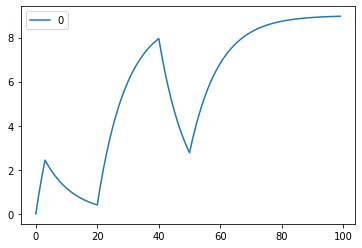

In [20]:
@partial(unroll_transform_with_state, dynamic=True)
def fun(x):
    return EWMA(1 / 10, adjust=True, ignore_na=False, return_info=True)(x)


rng = jax.random.PRNGKey(42)
params, state = fun.init(rng, x)
(res, info), final_state = fun.apply(params, state, rng, x)


res = pd.DataFrame(onp.array(res))


c1 = pd.DataFrame(info["com_eff"])
c1.plot()

# More checks

In [21]:
adjust = False
ignore_na = False

adjust = True
ignore_na = False


def run():
    x = jnp.ones((30,), "float64").at[0].set(-1).at[5:20].set(jnp.nan)

    @partial(unroll_transform_with_state)
    def fun(x):
        return EWMA(1 / 10, adjust=adjust, ignore_na=ignore_na, return_info=True)(x)

    rng = jax.random.PRNGKey(42)
    params, state = fun.init(rng, x)
    (res, info), final_state = fun.apply(params, state, rng, x)
    res = pd.Series(onp.array(res))

    ref_res = (
        pd.Series(onp.array(x))
        .ewm(alpha=1 / 10, adjust=adjust, ignore_na=ignore_na)
        .mean()
        .values
    )

    df = pd.concat(
        [
            pd.Series(x),
            pd.Series(onp.array(ref_res)),
            pd.Series(onp.array(res)),
        ],
        axis=1,
        keys=["x", "pandas", "wax"],
    )

    return df

    df = pd.concat(
        [
            pd.Series(x),
            ref_res,
            res,
            pd.Series(onp.array(info["mean"])),
            pd.Series(info["norm"]),
            pd.Series(onp.array(info["mean"])) / ref_res,
        ],
        axis=1,
        keys=["x", "pandas", "wax", "wax-mean", "wax-norm", "pandas-norm"],
    )
    df.plot()

<AxesSubplot:>

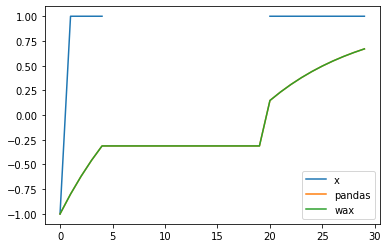

In [22]:
adjust = False
ignore_na = False
df = run()
df.plot()

<AxesSubplot:>

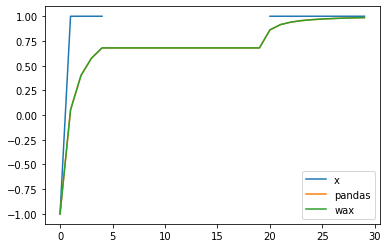

In [23]:
adjust = True
ignore_na = False
df = run()
df.plot()

<AxesSubplot:>

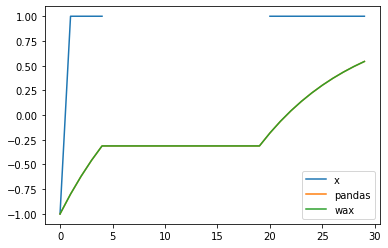

In [24]:
adjust = False
ignore_na = True
df = run()
df.plot()

<AxesSubplot:>

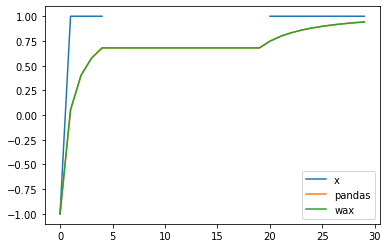

In [25]:
adjust = True
ignore_na = True
df = run()
df.plot()

<AxesSubplot:>

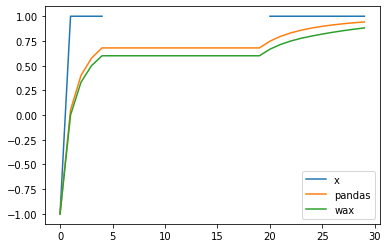

In [26]:
adjust = "linear"
ignore_na = True
df = run()
df.plot()

<AxesSubplot:>

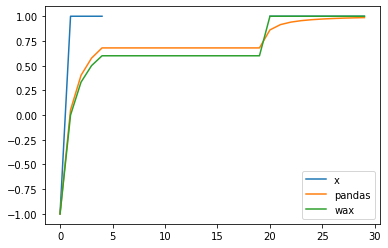

In [27]:
adjust = "linear"
ignore_na = False
df = run()
df.plot()

# Numba implementation

In [28]:
from wax.modules.ewma_numba import ewma

<AxesSubplot:>

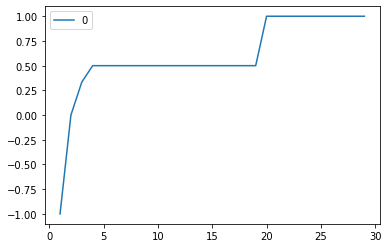

In [29]:
x = onp.ones((30,), "float64")
x[0] = onp.nan

x[1] = -1

x[5:20] = onp.nan
x = x.reshape(-1, 1)


res, state = ewma(com=10, adjust="linear")(x)
pd.DataFrame(res).plot()

In [39]:
ewma_apply = ewma(com=10, adjust="linear", min_periods=3)
res_full, _ = ewma_apply(x)

T = 10
res1, state = ewma_apply(x[:T])
res2, _ = ewma_apply(x[T:], state)
res12 = np.concatenate([res1, res2])
assert np.allclose(res_full, res12, equal_nan=True)
pd.concat([pd.DataFrame(res_full), pd.DataFrame(res12)], axis=1, keys=["full", "12"])

,full,12
,0,0
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,0.333333,0.333333
4,0.500000,0.500000
5,0.500000,0.500000
6,0.500000,0.500000
7,0.500000,0.500000
8,0.500000,0.500000


# Online pandas ewm

,tot,res1,res2
,0,0,0
0,NaN,NaN,NaN
1,-1.000000,-1.000000,NaN
2,0.000000,0.000000,NaN
3,0.333333,0.333333,NaN
4,0.500000,0.500000,NaN
5,0.500000,0.500000,NaN
6,0.500000,0.500000,NaN
7,0.500000,0.500000,NaN
8,0.500000,0.500000,NaN


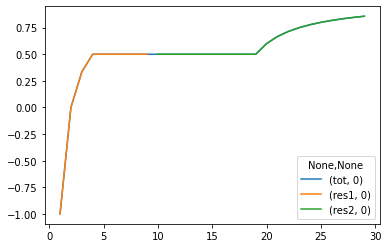

In [36]:
online_ewm = pd.DataFrame(x).ewm(10).online()
res_tot = online_ewm.mean()


data = pd.DataFrame(x)
online_ewm = data.iloc[:10].ewm(10).online()
res1 = online_ewm.mean()

res2 = online_ewm.mean(update=data.iloc[10:])

df = pd.concat([res_tot, res1, res2], keys=["tot", "res1", "res2"], axis=1)
df.plot()
df